In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh.io import curdoc, output_notebook
from bokeh.models import BoxZoomTool, ResetTool, PanTool, WheelZoomTool, HoverTool
from bokeh.transform import factor_cmap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from tqdm import tqdm
import warnings

from statsbombpy import sb

In [70]:
data = pd.read_csv("./data.csv")

In [71]:
data.shape

(9392, 59)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9392 entries, 0 to 9391
Data columns (total 59 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   period                              9392 non-null   int64  
 1   minute                              9392 non-null   int64  
 2   possession                          9392 non-null   int64  
 3   location_x                          9392 non-null   float64
 4   location_y                          9392 non-null   float64
 5   duration                            9392 non-null   float64
 6   first_time                          9392 non-null   bool   
 7   open_goal                           9392 non-null   bool   
 8   one_on_one                          9392 non-null   bool   
 9   statsbomb_xg                        9392 non-null   float64
 10  is_goal                             9392 non-null   bool   
 11  play_pattern_From Corner            9392 no

In [73]:
data.nunique()

period                                   5
minute                                 134
possession                             267
location_x                             434
location_y                             536
duration                              9354
first_time                               2
open_goal                                2
one_on_one                               2
statsbomb_xg                          9192
is_goal                                  2
play_pattern_From Corner                 2
play_pattern_From Counter                2
play_pattern_From Free Kick              2
play_pattern_From Goal Kick              2
play_pattern_From Keeper                 2
play_pattern_From Kick Off               2
play_pattern_From Throw In               2
play_pattern_Other                       2
play_pattern_Regular Play                2
position_Center Attacking Midfield       2
position_Center Back                     2
position_Center Defensive Midfield       2
position_Ce

<AxesSubplot:>

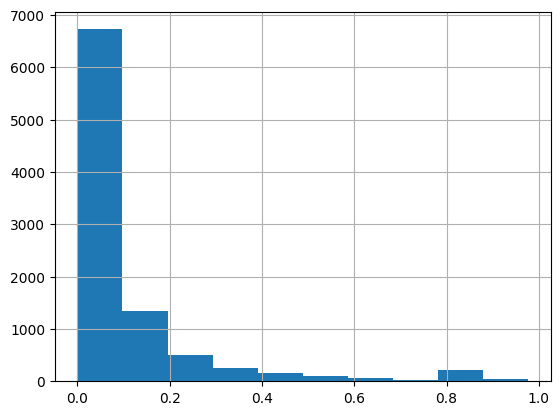

In [74]:
data["statsbomb_xg"].hist()

In [75]:
def plot_coordinates(x, y, title='Scatter Plot of X and Y Coordinates', color="cyan", color_map=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=800, height=600, title=title)

    if color_map is not None:
        p.scatter(x, y, size=8, color=color_map, alpha=0.5, legend_label='Data')
    else:
        p.scatter(x, y, size=8, color=color, alpha=0.5, legend_label='Data')


    p.x_range.start = 0
    p.y_range.start = 0
    p.x_range.end = 120
    p.y_range.end = 80

    p.xaxis.axis_label = 'X Coordinate'
    p.yaxis.axis_label = 'Y Coordinate'
    p.grid.visible = True

    hover = HoverTool(tooltips=[('X', '@x'), ('Y', '@y')])
    p.add_tools(hover)
    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [76]:
def plot_scatter(x, y, title='Scatter Plot of X and Y Coordinates', x_label='X', y_label='Y', color="cyan", color_map=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=800, height=600, title=title)

    if color_map is not None:
        p.scatter(x, y, size=8, color=color_map, alpha=0.5, legend_label='Data')
    else:
        p.scatter(x, y, size=8, color=color, alpha=0.5, legend_label='Data')


    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.grid.visible = True

    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    trendline = slope * x + intercept
    p.line(x, trendline, line_color='blue', line_width=1, legend_label='Trendline')

    hover = HoverTool(tooltips=[('X', '@x'), ('Y', '@y')])
    p.add_tools(hover)
    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [77]:
def plot_histogram(data, bins=10, title='Frequency of Data', x_label='Value', y_label='Frequency', is_goal=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=800, height=600, title=title)
    hist, edges = np.histogram(data, bins=bins)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='grey', line_color='white', alpha=0.4)

    hist, edges = np.histogram(data[is_goal == True], bins=bins)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='cyan', line_color='white', alpha=0.4)

    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.grid.visible = True

    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [78]:
def plot_bar_chart(data_df, column):
    value_counts = data_df[column].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Frequency of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

In [79]:
def plot_area_chart(sequence):
    plt.fill_between(range(len(sequence)), sequence, color="skyblue", alpha=0.4)
    plt.plot(sequence, color="Slateblue", alpha=0.6, linewidth=2)
    plt.xlabel("Threshold (times 10)")
    plt.ylabel("F1 score")
    plt.title("ROC")
    plt.show()

In [80]:
data = data[data["type_Penalty"] == False]

In [81]:
plot_coordinates(data['location_x'], data['location_y'], "Shot Locations", color_map=data["is_goal"].map({True: 'cyan', False: 'grey'}))

Loading BokehJS ...

In [82]:
plot_histogram(data["location_x"], bins=120, title="Distribution of x-coordinates", x_label="x-coordinate", is_goal=data["is_goal"])

Loading BokehJS ...

In [83]:
plot_histogram(data["location_y"], bins=120, title="Distribution of y-coordinates", x_label="y-coordinate", is_goal=data["is_goal"])

Loading BokehJS ...

In [84]:
shots_per_minute = data['minute'].value_counts().sort_index()[:90]
plot_scatter(data['minute'].unique()[:90], shots_per_minute, "Shots per Minute", x_label="Minute", y_label="Number of Shots", color="grey")

Loading BokehJS ...

In [85]:
goals_per_minute = data[data["is_goal"] == True]['minute'].value_counts().sort_index()[:90]
plot_scatter(data['minute'].unique()[:90], goals_per_minute, "Goals per Minute", x_label="Minute", y_label="Number of Goals", color="cyan")

Loading BokehJS ...

In [86]:
plot_histogram(data["minute"], bins=130, title="Distribution of shot times", x_label="Minute", is_goal=data["is_goal"])

Loading BokehJS ...

In [87]:
restricted_data = data[data["minute"] < 100]
restricted_data = restricted_data[restricted_data["location_x"] > 70]
plot_scatter(restricted_data['minute'], restricted_data["location_x"], "x-coordinate of Shots by Minute", x_label="Minute", y_label="x-coordinate", color_map=restricted_data["is_goal"].map({True: 'cyan', False: 'grey'}))

Loading BokehJS ...

In [88]:
restricted_data = data[data["minute"] < 100]
mean_location_y = restricted_data['location_y'].mean()
deviation_from_mean = abs(restricted_data["location_y"] - mean_location_y)
plot_scatter(restricted_data['minute'], deviation_from_mean, "y-coordinate of Shots by Minute", x_label="Minute", y_label="y-coordinate", color_map=restricted_data["is_goal"].map({True: 'cyan', False: 'grey'}))

Loading BokehJS ...

In [89]:
data.columns

Index(['period', 'minute', 'possession', 'location_x', 'location_y',
       'duration', 'first_time', 'open_goal', 'one_on_one', 'statsbomb_xg',
       'is_goal', 'play_pattern_From Corner', 'play_pattern_From Counter',
       'play_pattern_From Free Kick', 'play_pattern_From Goal Kick',
       'play_pattern_From Keeper', 'play_pattern_From Kick Off',
       'play_pattern_From Throw In', 'play_pattern_Other',
       'play_pattern_Regular Play', 'position_Center Attacking Midfield',
       'position_Center Back', 'position_Center Defensive Midfield',
       'position_Center Forward', 'position_Goalkeeper',
       'position_Left Attacking Midfield', 'position_Left Back',
       'position_Left Center Back', 'position_Left Center Forward',
       'position_Left Center Midfield', 'position_Left Defensive Midfield',
       'position_Left Midfield', 'position_Left Wing',
       'position_Left Wing Back', 'position_Right Attacking Midfield',
       'position_Right Back', 'position_Right Center

In [94]:
play_pattern = data[['play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play']].idxmax(axis=1).apply(lambda x: x.replace("play_pattern_", ""))
play_pattern_numeric, _ = pd.factorize(play_pattern)
plot_histogram(play_pattern_numeric, bins=9, title="Frequency of shots per play pattern", x_label="Plays", is_goal=data["is_goal"])
play_pattern.value_counts()

Loading BokehJS ...

Regular Play      2787
From Free Kick    2147
From Throw In     1662
From Corner       1582
From Counter       397
From Goal Kick     334
From Keeper        182
From Kick Off      103
Other                6
Name: count, dtype: int64

In [91]:
restricted_data = data[data["minute"] < 100]
restricted_data = restricted_data[restricted_data["location_x"] > 70]
plot_coordinates(data['location_x'], data["location_y"], "Location of shots by play pattern", color_map=play_pattern.map({"Regular Play": 'cyan', "From Free Kick": 'red', "From Throw In": 'darkblue', "From Corner": 'green', "From Counter": 'yellow', "From Goal Kick": 'orange', "From Keeper": 'pink', "From Kick Off": 'purple', "Other": 'brown'}))

Loading BokehJS ...